In [ ]:
!pip install ultralytics
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully u

In [1]:
import cv2
import random
import numpy as np
from pathlib import Path
import einops
import seaborn as sns

from ultralytics import YOLO
#from ultralytics.utils.plotting import save_one_box

import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

ModuleNotFoundError: No module named 'cv2'

In [ ]:
!pip list --format=freeze | grep -v "google-colab" | grep -v "colabtools" > requirements.txt

In [ ]:
seg_model = YOLO('yolov8n.pt')



def pre_processar(frame):
  #print(f'frame shape{frame.shape}')
  result = seg_model.predict(frame, classes=[0], stream=True, verbose=False)
  for r in result:
    boxes = r.boxes
    if(len(boxes) != 0):
    # Extract bounding box coordinates
      x1, y1, x2, y2 = boxes[0].xyxy[0].tolist()
      frame = frame[int(y1):int(y2),int(x1):int(x2)]
      #print('achei viu')
    #frame_int = (frame * 255).astype(np.uint8)

    #frame_int[:, :, 0] = cv2.equalizeHist(frame_int[:, :, 0])
    #frame_int[:, :, 1] = cv2.equalizeHist(frame_int[:, :, 1])
    #frame_int[:, :, 2] = cv2.equalizeHist(frame_int[:, :, 2])

    #frame_int = frame_int.astype(np.float32) / 255.0

  return frame


100%|██████████| 6.25M/6.25M [00:00<00:00, 86.8MB/s]


In [ ]:
'''def load_video(video_path):
  cap = cv2.VideoCapture(video_path)
  frames = []
  while True:
    ret, frame = cap.read()
    if not ret:
      break
    frame = cv2.resize(frame, (244, 244))
    frames.append(frame)
  cap.release()
  return tf.convert_to_tensor(frames, dtype=tf.float32) / 255

def get_label(path):
  return load_video(path, )


#train dataset
train = tf.data.Dataset.list_files("train/*.avi", shuffle=True) '''


'def load_video(video_path):\n  cap = cv2.VideoCapture(video_path)\n  frames = []\n  while True:\n    ret, frame = cap.read()\n    if not ret:\n      break\n    frame = cv2.resize(frame, (244, 244))\n    frames.append(frame)\n  cap.release()\n  return tf.convert_to_tensor(frames, dtype=tf.float32) / 255\n\ndef get_label(path):\n  return load_video(path, )\n\n\n#train dataset\ntrain = tf.data.Dataset.list_files("train/*.avi", shuffle=True) '

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = pre_processar(frame)
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
n_frames = 10
batch_size = 8

train_dir = Path('drive/MyDrive/projeto_cv/surf_dataset_03/train')
val_dir = Path('drive/MyDrive/projeto_cv/surf_dataset_03/val')
test_dir = Path('drive/MyDrive/projeto_cv/surf_dataset_03/test')

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_dir, n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_dir, n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_dir, n_frames),
                                         output_signature= output_signature)
test_ds = test_ds.batch(batch_size)

In [ ]:
# Check one batch from val_ds
for frames, labels in test_ds.take(1):
    print("Frames shape:", frames.shape)  # Should be (batch_size, n_frames, H, W, 3)
    print("Frames dtype:", frames.dtype)  # Should be tf.float32
    print("Labels shape:", labels.shape)  # Should be (batch_size,)
    print("Labels dtype:", labels.dtype)  # Should be tf.int16

Frames shape: (8, 10, 224, 224, 3)
Frames dtype: <dtype: 'float32'>
Labels shape: (8,)
Labels dtype: <dtype: 'int16'>


In [ ]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224


In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)


In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)


In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)


In [ ]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])


In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos


In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)


In [ ]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])


In [ ]:
history = model.fit(x = train_ds,
                    epochs = 50,
                    validation_data = val_ds)


Epoch 1/50
      7/Unknown 234s 28s/step - accuracy: 0.3197 - loss: 1.6107

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


7/7 ━━━━━━━━━━━━━━━━━━━━ 278s 35s/step - accuracy: 0.3376 - loss: 1.5637 - val_accuracy: 0.3750 - val_loss: 1.7710
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 275s 29s/step - accuracy: 0.5422 - loss: 0.8881 - val_accuracy: 0.6250 - val_loss: 0.6896
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 263s 37s/step - accuracy: 0.5071 - loss: 0.7787 - val_accuracy: 0.3750 - val_loss: 1.0307
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 217s 30s/step - accuracy: 0.5521 - loss: 0.7392 - val_accuracy: 0.6250 - val_loss: 0.6598
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 219s 30s/step - accuracy: 0.5861 - loss: 0.6953 - val_accuracy: 0.3750 - val_loss: 0.7196
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 321s 39s/step - accuracy: 0.4431 - loss: 0.7568 - val_accuracy: 0.6250 - val_loss: 0.6501
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 216s 29s/step - accuracy: 0.6753 - loss: 0.5917 - val_accuracy: 0.6250 - val_loss: 0.6920
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 226s 31s/step - accuracy: 0.8120 - loss: 0.5364 - val_accuracy: 0.6250 - val_loss: 0.6965
Epo

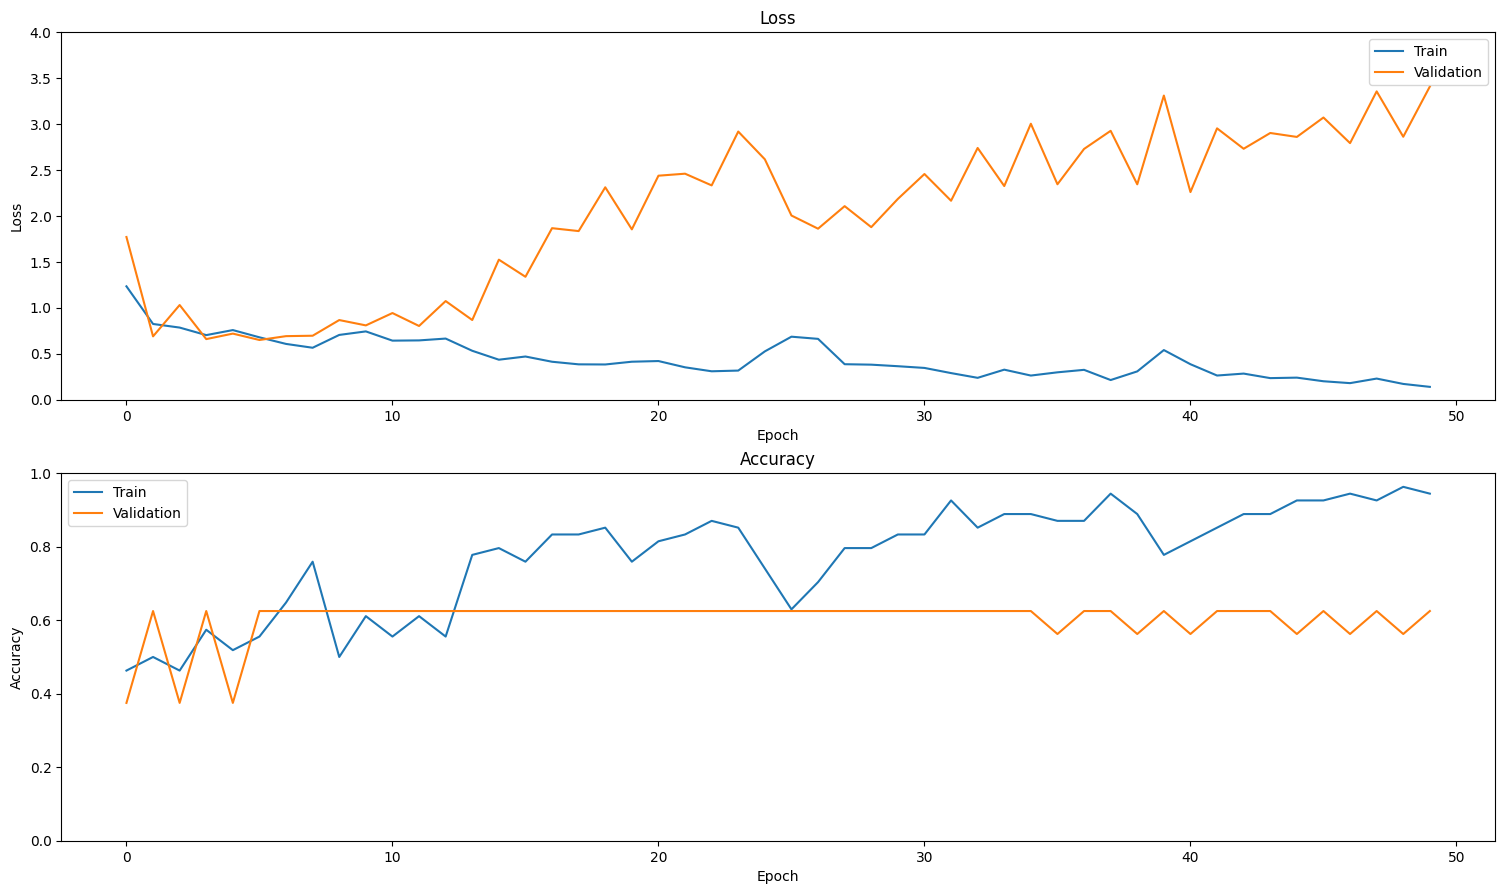

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)


In [ ]:
model.evaluate(test_ds, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 49s 16s/step - accuracy: 0.6969 - loss: 2.5928


{'accuracy': 0.550000011920929, 'loss': 3.873387098312378}

In [ ]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted


In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)


In [ ]:
fg = FrameGenerator(train_dir, n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())


7/7 ━━━━━━━━━━━━━━━━━━━━ 119s 15s/step


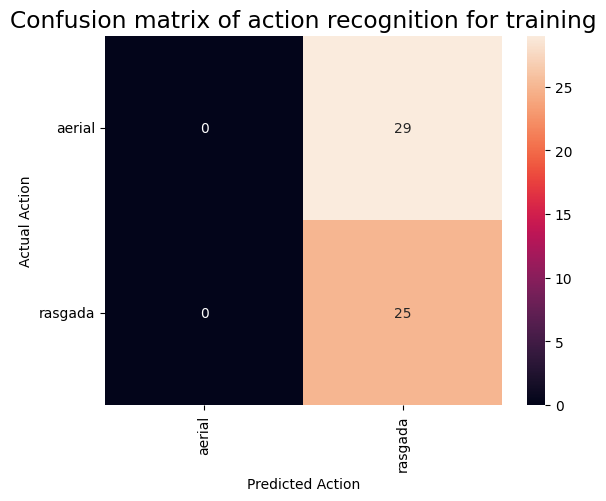

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')


3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 12s/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


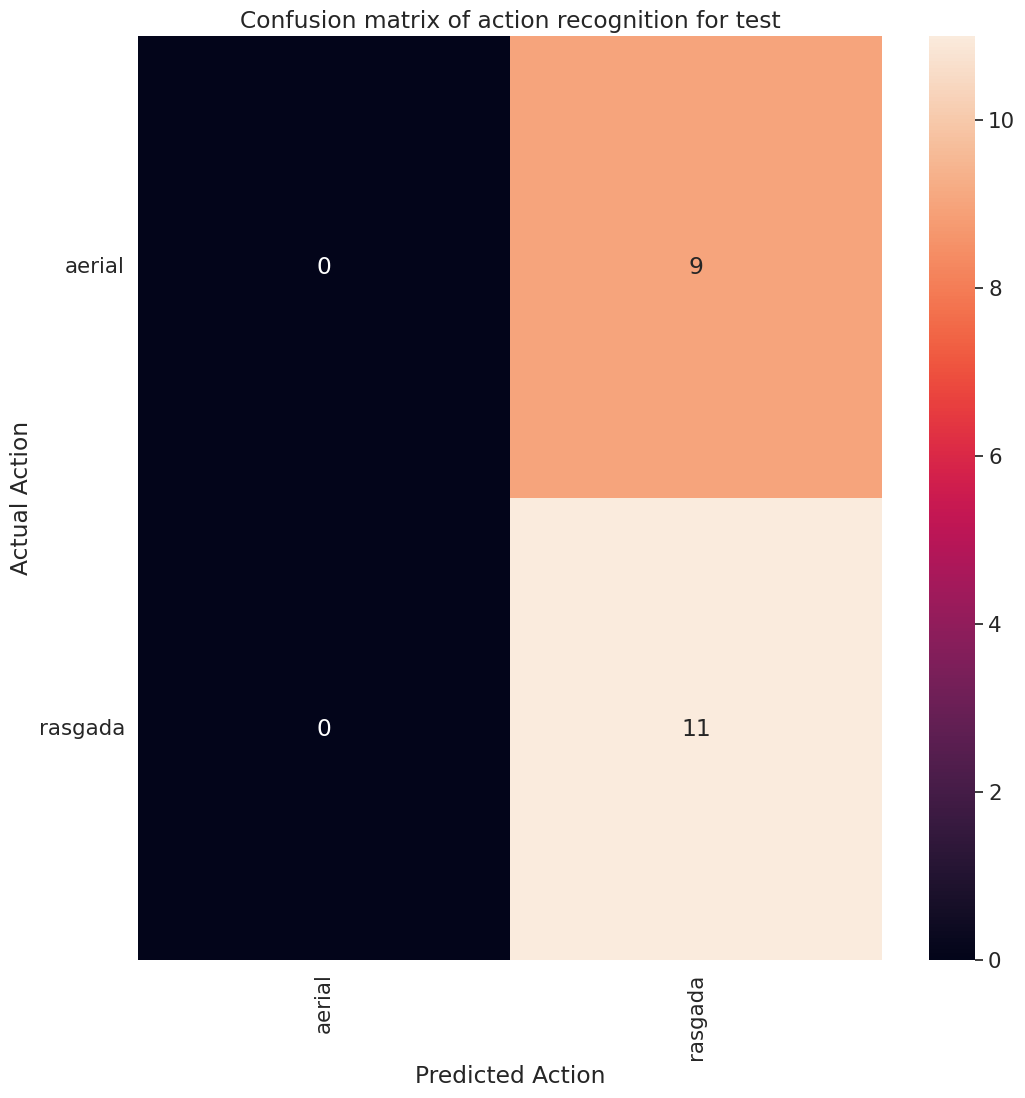

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')


In [ ]:
  !pwd

/content


In [ ]:
%cd drive/MyDrive/projeto_cv/

/content/drive/MyDrive/projeto_cv


In [ ]:
model.save('pre_processado.keras')